# 30-Day Hospital Readmission Risk — Clinical Analytics Notebook

**Clinical aim.** Estimate 30-day readmission risk at discharge to prioritize proactive outreach (early clinic visit, medication reconciliation, home health). The model is designed to support value-based care and reduce avoidable readmissions.

**Dataset.** `data/hospital_readmissions_30k.csv`  
**Outcome.** `readmitted_30_days` ∈ {Yes, No} (mapped to 1/0)  
**Repository.** https://github.com/albertokabore/Hospital-Readmission-Prediction

**Decision framing.**  
- Primary: *Recall (Sensitivity)* — identify high-risk patients to avoid missed opportunities.  
- Secondary: *Precision* — efficient use of follow-up resources.  
- Summary: AUROC and AUPRC given class imbalance.

**Method overview.**  
- Robust preprocessing (impute, encode, scale).  
- Baselines + ensembles (DT, RF, GB, AdaBoost, Bagging, XGBoost).  
- Imbalance strategies (SMOTE, undersampling).  
- Hyperparameter tuning with `RandomizedSearchCV`.  
- Interpretability (feature importance / coefficients).


In [153]:
!pip install scikit-learn imbalanced-learn xgboost pandas numpy matplotlib seaborn


In [154]:
!pip install --upgrade -q threadpoolctl


In [155]:
# Import all required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [156]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.style.use("seaborn-v0_8-whitegrid")

RANDOM_STATE = 42
DATA_PATH = "Dataset_Hospital_readmissions_30k.csv"  # adjust path if needed

print(" HOSPITAL READMISSION ANALYSIS INITIALIZED")

 HOSPITAL READMISSION ANALYSIS INITIALIZED


In [157]:
import os

print("Current working directory:", os.getcwd())
print("Files here:", os.listdir())

Current working directory: c:\Users\alber\Hospital-Readmission-Prediction\notebooks
Files here: ['Readmission_Project.ipynb']


## 0. CONFIGURATION


In [158]:
import os

target_name = "Dataset_Hospital_readmissions_30k.csv"
found_paths = []

for dirpath, dirnames, filenames in os.walk(os.getcwd()):
    if target_name in filenames:
        found_paths.append(os.path.join(dirpath, target_name))

print("Found paths:")
for p in found_paths:
    print(" -", p)


Found paths:


In [159]:
df = pd.read_csv(r"C:\Users\alber\Hospital-Readmission-Prediction\data\Dataset_Hospital_readmissions_30k.csv")


# 1. DATA LOADING AND INITIAL EXPLORATION


### load data

In [167]:
df = pd.read_csv(r"C:\Users\alber\Hospital-Readmission-Prediction\data\Dataset_Hospital_readmissions_30k.csv")


In [192]:
print("\n" + "=" * 70)
print("1. DATA LOADING AND INITIAL EXPLORATION")
print("=" * 70)


1. DATA LOADING AND INITIAL EXPLORATION


In [193]:
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns\n")

Dataset loaded: 30000 rows, 12 columns



In [194]:
print("Column dtypes:")
print(df.dtypes.value_counts(), "\n")

print("First 5 rows:")
print(df.head(), "\n")

Column dtypes:
int64      6
object     5
float64    1
Name: count, dtype: int64 

First 5 rows:
   patient_id  age  gender blood_pressure  cholesterol    bmi diabetes  \
0           1   74   Other         130/72          240 31.500      Yes   
1           2   46  Female         120/92          292 36.300       No   
2           3   89   Other         135/78          153 30.300       No   
3           4   84  Female         123/80          153 31.500       No   
4           5   32   Other         135/84          205 18.400       No   

  hypertension  medication_count  length_of_stay discharge_destination  \
0           No                 5               1      Nursing_Facility   
1           No                 4               3      Nursing_Facility   
2          Yes                 1               1                  Home   
3          Yes                 3              10                  Home   
4          Yes                 6               4      Nursing_Facility   

   readmitted_

In [195]:
print("Memory usage: "
      f"{df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

Memory usage: 9.23 MB


In [196]:
# Missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    "MissingCount": missing_values,
    "MissingPct": missing_percentage
}).sort_values("MissingPct", ascending=False)

print("\nMissing values summary (top 20):")
print(missing_df.head(20))



Missing values summary (top 20):
                       MissingCount  MissingPct
patient_id                        0       0.000
age                               0       0.000
gender                            0       0.000
blood_pressure                    0       0.000
cholesterol                       0       0.000
bmi                               0       0.000
diabetes                          0       0.000
hypertension                      0       0.000
medication_count                  0       0.000
length_of_stay                    0       0.000
discharge_destination             0       0.000
readmitted_30_days                0       0.000


In [197]:
# Describe numeric and categorical
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_all = df.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print(f"\nNumeric features: {len(numeric_cols_all)}")
print(numeric_cols_all)
print(f"\nCategorical features: {len(categorical_cols_all)}")
print(categorical_cols_all)

print("\nDescriptive statistics (numeric):")
print(df[numeric_cols_all].describe().T)


Numeric features: 7
['patient_id', 'age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay', 'readmitted_30_days']

Categorical features: 5
['gender', 'blood_pressure', 'diabetes', 'hypertension', 'discharge_destination']

Descriptive statistics (numeric):
                       count      mean      std     min      25%       50%  \
patient_id         30000.000 15000.500 8660.398   1.000 7500.750 15000.500   
age                30000.000    53.884   21.056  18.000   36.000    54.000   
cholesterol        30000.000   225.260   43.586 150.000  188.000   225.000   
bmi                30000.000    28.946    6.348  18.000   23.400    28.900   
medication_count   30000.000     5.012    3.166   0.000    2.000     5.000   
length_of_stay     30000.000     5.503    2.867   1.000    3.000     5.000   
readmitted_30_days 30000.000     0.122    0.328   0.000    0.000     0.000   

                         75%       max  
patient_id         22500.250 30000.000  
age                   72.0

# =============================================================================
# 2. TARGET VARIABLE ANALYSIS
# =============================================================================

In [201]:
print("\n" + "=" * 70)
print("2. TARGET VARIABLE ANALYSIS")
print("=" * 70)

# Try a few common target names, starting with 'readmitted'
candidate_targets = ["readmitted", "readmitted_30_days", "Readmitted"]
target_col = None

for col in candidate_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    print("Available columns:\n", df.columns.tolist())
    raise ValueError("Target column not found. Check the actual name in df.columns.")

print(f"Using target column: {target_col}")

# If target is not already 0/1, map typical text values to 0/1
if df[target_col].dtype == "object":
    # you can extend this mapping if your values are different
    mapping = {
        "Yes": 1, "No": 0,
        "Y": 1, "N": 0,
        "Readmitted": 1, "Not Readmitted": 0,
        1: 1, 0: 0
    }
    df[target_col] = df[target_col].map(mapping)

# Safety check: make sure it is numeric now
if not np.issubdtype(df[target_col].dtype, np.number):
    print("Unique values in target:", df[target_col].unique())
    raise ValueError("Target column is not numeric and could not be mapped to 0/1.")

# Now compute distribution
target_distribution = df[target_col].value_counts().sort_index()
target_percentage = (target_distribution / len(df)) * 100

print("Target distribution (readmitted):")
for val, count in target_distribution.items():
    if val == 0:
        label = "Not Readmitted"
    elif val == 1:
        label = "Readmitted"
    else:
        label = f"Class {val}"
    print(f"• {label}: {count} patients ({target_percentage[val]:.2f}%)")



2. TARGET VARIABLE ANALYSIS
Using target column: readmitted_30_days
Target distribution (readmitted):
• Not Readmitted: 26326 patients (87.75%)
• Readmitted: 3674 patients (12.25%)


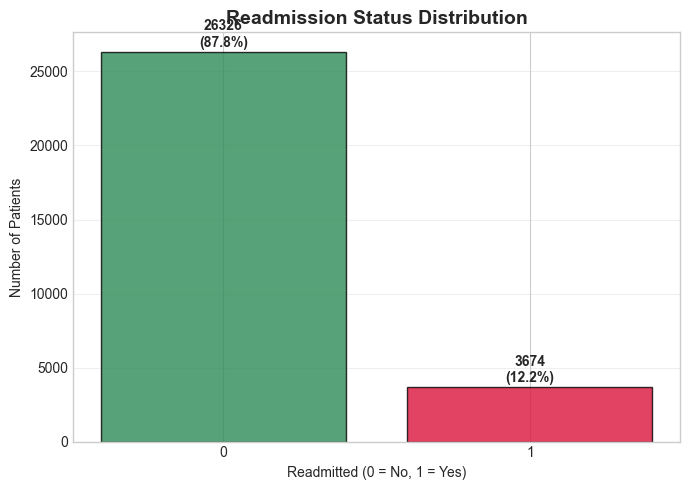

In [202]:
plt.figure(figsize=(7, 5))
colors = ["#2E8B57", "#DC143C"]
bars = plt.bar(target_distribution.index, target_distribution.values,
               color=colors, alpha=0.8, edgecolor="black")
plt.title("Readmission Status Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Readmitted (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.xticks([0, 1])
plt.grid(axis="y", alpha=0.3)
for idx, bar in enumerate(bars):
    height = bar.get_height()
    val = target_distribution.index[idx]
    pct = target_percentage[val]
    plt.text(bar.get_x() + bar.get_width() / 2, height + len(df) * 0.005,
             f"{height}\n({pct:.1f}%)", ha="center", va="bottom", fontweight="bold")
plt.tight_layout()
plt.show()


In [203]:
positive_rate = target_percentage.get(1, 0.0)
class_ratio = target_distribution[0] / max(target_distribution.get(1, 1), 1)
baseline_acc = target_percentage.max()

print("\nTarget summary:")
print(f"• Readmission rate: {positive_rate:.2f}%")
print(f"• Class imbalance ratio (0:1): {class_ratio:.2f}:1")
print(f"• Baseline accuracy (majority class): {baseline_acc:.2f}%")



Target summary:
• Readmission rate: 12.25%
• Class imbalance ratio (0:1): 7.17:1
• Baseline accuracy (majority class): 87.75%


# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

In [204]:
# =============================================================================
print("\n" + "=" * 70)
print("3. EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 70)


3. EXPLORATORY DATA ANALYSIS (EDA)


In [205]:

# 3.1 Numeric feature list excluding target
numeric_cols = [c for c in numeric_cols_all if c != target_col]



4. FEATURE ENGINEERING AND TRANSFORMATIONS
Creating clinical complexity score...


• Clinical complexity score and categories created.
Creating interaction features...



4. FEATURE ENGINEERING AND TRANSFORMATIONS
Creating clinical complexity score...
• Clinical complexity score and categories created.
Creating interaction features...
• medications_per_day created
• bmi_cholesterol_ratio created
Applying mathematical transformations...
• Log and square root transformations applied to length_of_stay
• Log and square root transformations applied to medication_count
• Log and square root transformations applied to cholesterol

Created 18 new features:
• systolic_bp
• diastolic_bp
• diabetes_flag
• hypertension_flag
• length_of_stay_scaled
• medication_count_scaled
• diabetes_flag_scaled
• hypertension_flag_scaled
• clinical_complexity_score
• complexity_category
• medications_per_day
• bmi_cholesterol_ratio
• length_of_stay_log
• length_of_stay_sqrt
• medication_count_log
• medication_count_sqrt
• cholesterol_log
• cholesterol_sqrt


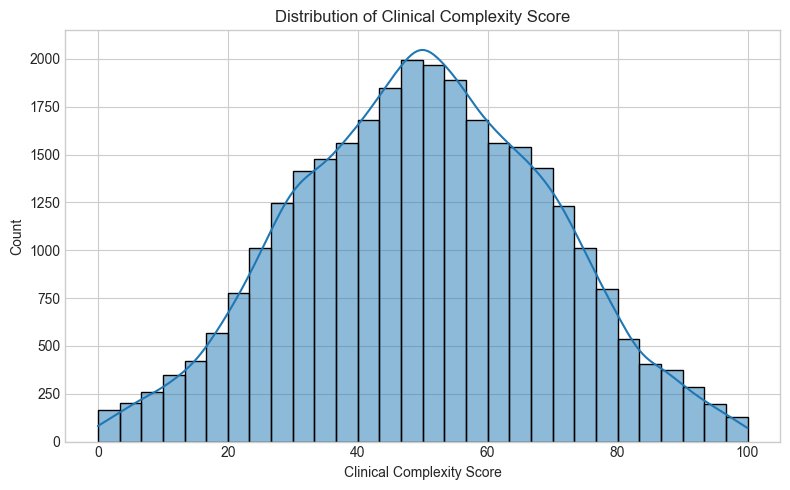

# =============================================================================
# 5. VALIDATION OF ENGINEERED FEATURES
# =============================================================================